Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected features after SelectKBest: ['RBC', 'Hb', 'MCV', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']

--- Decision Tree Classifier with GridSearchCV ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best ROC AUC score from GridSearchCV (Decision Tree): 0.7782
Accuracy: 0.71
ROC AUC Score: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.46      0.61        80
           1       0.64      0.95      0.76        80

    accuracy                           0.71       160
   macro avg       0.77      0.71      0.69       160
weighted avg       0.77      0.71      0.69    

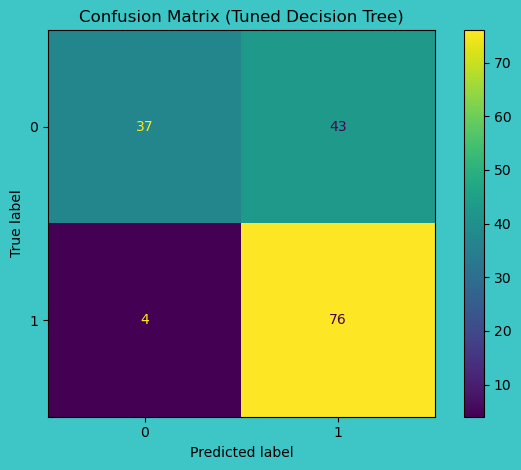

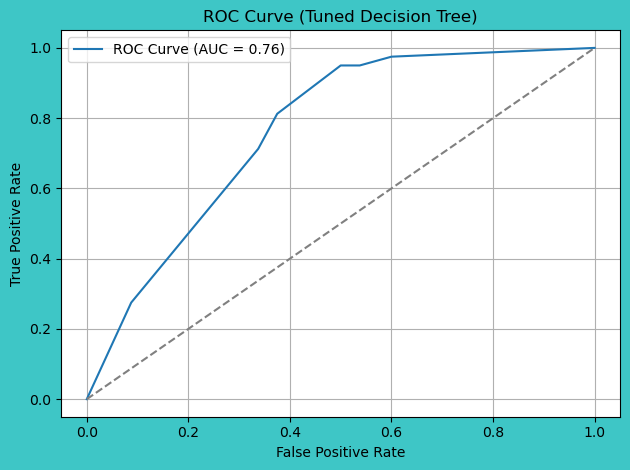

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']

    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:  # age >= 12
        if gender == 0:  # Female
            return hb < 12.0
        elif gender == 1:  # Male
            return hb < 13.0
        else:
            return False  # handle unknown gender

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    # Determine threshold based on age and gender
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0

    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features for modeling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# Feature selection using SelectKBest (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=min(10, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)

selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print("Selected features after SelectKBest:", selected_features)

# Balance training data with SMOTE (Keeping it as per your code, but consider removing if balanced)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)


# --- START OF HYPERPARAMETER TUNING FOR DECISION TREE CLASSIFIER ---
print("\n--- Decision Tree Classifier with GridSearchCV ---")

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None], # Max depth of the tree
    'min_samples_leaf': [1, 5, 10, 20], # Minimum samples required to be at a leaf node
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split an internal node
    'criterion': ['gini', 'entropy']   # Function to measure the quality of a split
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42), # Pass the unfitted model
    param_grid_dt,
    cv=5,
    scoring='roc_auc', # Optimize for ROC AUC
    n_jobs=-1, # Use all available CPU cores
    verbose=1 # To see the progress
)

# Fit GridSearchCV to the balanced training data
grid_search_dt.fit(X_train_balanced, y_train_balanced)

print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print(f"Best ROC AUC score from GridSearchCV (Decision Tree): {grid_search_dt.best_score_:.4f}")

# Use the best estimator found by GridSearchCV
model = grid_search_dt.best_estimator_
# --- END OF HYPERPARAMETER TUNING ---


# Predict probabilities for class 1 using the best Decision Tree model
predicted_proba = model.predict_proba(X_test_selected)[:, 1]

# Convert probabilities to percentages
predicted_proba_percent = predicted_proba * 100

# threshold (keeping your specified threshold of 0.3)
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# DataFrame for predictions with original indexes
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Cholesterol, Diabetes, BP (convert 1/0 back to Yes/No)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

# Add Anemia Severity descriptive label for test set
# For display, re-calculate these from the original data
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

temp_data_for_display['Anemia_Severity_Display'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
temp_data_for_display['Anemia_Display'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display['Anemia_Severity_Display']
predictions_df['Anemia'] = temp_data_for_display['Anemia_Display']

# Save predictions
predictions_df.to_csv('predictions_dt_tuned.csv') # Changed filename for Decision Tree
print("Predictions saved to predictions_dt_tuned.csv")

# Print training/test class distribution for reference
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot and get the figure and axes
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Tuned Decision Tree)") # Updated title
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned Decision Tree)') # Updated title
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

